In [ ]:
# ==============================================================================
# AIE1014 - AI Applied Project: Milestone II Final Notebook
# Project: NutriAI - AI-Enhanced Personal Nutrition and Activity Assistant
# Team: Meet Patel, Aashish Giri, Sabin Khatri, Jaykesh J Awal
# ==============================================================================

# ==============================================================================
# Section 1: Setup and Initial Data Loading
# ==============================================================================


In [ ]:
# --- 1.1: Import Core Dependencies ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Configure notebook settings
import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)


In [ ]:
# --- 1.2: Load Base Food Dataset ---

try:
    file_path = 'daily_food_nutrition_dataset.csv'
    df_food_base = pd.read_csv(file_path)
    print("Dataset loaded successfully.")
    print("Shape of base food dataset:", df_food_base.shape)
except FileNotFoundError:
    print("ERROR: 'daily_food_nutrition_dataset.csv' not found.")
    print("Please upload the dataset to your Colab session or mount your Google Drive and update the file path.")


Dataset loaded successfully.
Shape of base food dataset: (10000, 14)


In [ ]:
# ==============================================================================
# Section 2: Data Curation
# ==============================================================================
# To make the project manageable and realistic, we first curate the base food
# dataset. We'll select relevant columns and filter for common food items to
# serve as the foundation for our synthetic data generation.

print("\n--- Section 2: Curating Base Food Dataset ---")

# Select relevant columns
required_cols = ['Food_Item', 'Category', 'Calories (kcal)', 'Protein (g)', 'Carbohydrates (g)', 'Fat (g)', 'Fiber (g)', 'Sugars (g)']
df_food_curated = df_food_base[required_cols].copy()

# Data Cleaning: Handle potential missing values and unrealistic entries
df_food_curated.dropna(inplace=True)
df_food_curated = df_food_curated[df_food_curated['Calories (kcal)'] > 0] # Remove zero-calorie entries

# To make sampling more meaningful, let's create a 'high_protein' flag
df_food_curated['is_high_protein'] = (df_food_curated['Protein (g)'] >= 15).astype(int)

print("Curated food dataset shape:", df_food_curated.shape)
print("Curated food dataset preview:")
print(df_food_curated.head())


--- Section 2: Curating Base Food Dataset ---
Curated food dataset shape: (10000, 9)
Curated food dataset preview:
        Food_Item Category  Calories (kcal)  Protein (g)  Carbohydrates (g)  \
0            Eggs     Meat              173         42.4               83.7   
1           Apple   Fruits               66         39.2               13.8   
2  Chicken Breast     Meat              226         27.1               79.1   
3          Banana   Fruits              116         43.4               47.1   
4          Banana   Fruits              500         33.9               75.8   

   Fat (g)  Fiber (g)  Sugars (g)  is_high_protein  
0      1.5        1.5        12.7                1  
1      3.2        2.6        12.2                1  
2     25.8        3.2        44.7                1  
3     16.1        6.5        44.1                1  
4     47.0        7.8        19.4                1  


In [ ]:
# ==============================================================================
# Section 3: Synthetic Data Generation Pipeline
# ==============================================================================
# We generate a dataset of "user-days" to train our
# AI model. Each row will represent a full day of activity and nutrition for a
# specific user persona. This avoids the data leakage issue from the initial
# exploration and creates a realistic prediction problem.

print("\n--- Section 3: Generating Synthetic User-Day Data ---")



--- Section 3: Generating Synthetic User-Day Data ---


In [ ]:
# --- 3.1: Define User Personas ---
personas = {
    'Weight_Loss_Focus': {
        'calorie_target': 1800,
        'protein_target': 120,
        'activity_level': 'moderate',
        'dietary_preference': 'balanced' # No strong bias in food sampling
    },
    'Muscle_Gain_Focus': {
        'calorie_target': 2800,
        'protein_target': 180,
        'activity_level': 'high',
        'dietary_preference': 'high_protein' # Will preferentially sample high protein foods
    },
    'Sedentary_Lifestyle': {
        'calorie_target': 2000,
        'protein_target': 80,
        'activity_level': 'low',
        'dietary_preference': 'convenience' # Might sample higher calorie/fat foods
    }
}


In [ ]:
# --- 3.2: Define Activities and MET values for Calorie Expenditure ---
activities = {
    'Running': 8.0,
    'Weightlifting': 5.0,
    'Cycling': 6.0,
    'Walking': 3.5,
    'Desk Work': 1.5,
    'Resting': 1.0
}
# A simple function to estimate calorie expenditure
def estimate_calories_burned(activity, duration_minutes, weight_kg=70):
    met = activities.get(activity, 1.0)
    return (met * 3.5 * weight_kg) / 200 * duration_minutes

In [ ]:
# --- 3.3: Data Generation Logic ---
def generate_synthetic_data(num_users_per_persona, num_days, food_df, personas_dict):
    daily_records = []
    user_id_counter = 0

    for persona_name, persona_details in personas_dict.items():
        for i in range(num_users_per_persona):
            user_id = user_id_counter
            for day in range(num_days):
                # --- Generate Daily Meals ---
                daily_meals = []
                num_meals = random.randint(3, 5)

                if persona_details['dietary_preference'] == 'high_protein':
                    # Bias sampling towards high-protein foods
                    weights = food_df['is_high_protein'] * 5 + 1 # 5x more likely to pick high protein
                else:
                    weights = None # Uniform sampling

                daily_meals_df = food_df.sample(n=num_meals, weights=weights, replace=True)

                # --- Generate Daily Activity ---
                if persona_details['activity_level'] == 'high':
                    activity = random.choice(['Running', 'Weightlifting'])
                    duration = random.randint(45, 90)
                elif persona_details['activity_level'] == 'moderate':
                    activity = random.choice(['Cycling', 'Walking'])
                    duration = random.randint(30, 60)
                else: # low
                    activity = random.choice(['Desk Work', 'Resting'])
                    duration = random.randint(120, 240)

                calories_expended = estimate_calories_burned(activity, duration)

                # --- Aggregate Daily Stats ---
                total_calories = daily_meals_df['Calories (kcal)'].sum()
                total_protein = daily_meals_df['Protein (g)'].sum()
                total_carbs = daily_meals_df['Carbohydrates (g)'].sum()
                total_fat = daily_meals_df['Fat (g)'].sum()

                # --- Create Target Label ---
                protein_target_met = 1 if total_protein >= persona_details['protein_target'] else 0

                daily_records.append({
                    'user_id': user_id,
                    'day': day,
                    'persona_type': persona_name,
                    'activity_level': persona_details['activity_level'],
                    'calories_expended': calories_expended,
                    'total_calories_kcal': total_calories,
                    'total_protein_g': total_protein,
                    'total_carbs_g': total_carbs,
                    'total_fat_g': total_fat,
                    'protein_target_g': persona_details['protein_target'],
                    'calorie_target_kcal': persona_details['calorie_target'],
                    'protein_target_met': protein_target_met # Our target variable
                })
            user_id_counter += 1

    return pd.DataFrame(daily_records)

# Generate the dataset
df_generated = generate_synthetic_data(
    num_users_per_persona=50,
    num_days=14,
    food_df=df_food_curated,
    personas_dict=personas
)

print("Synthetic user-day dataset generated successfully.")
print("Shape of generated dataset:", df_generated.shape)
print("Generated dataset preview:")
print(df_generated.head())



Synthetic user-day dataset generated successfully.
Shape of generated dataset: (2100, 12)
Generated dataset preview:
   user_id  day       persona_type activity_level  calories_expended  \
0        0    0  Weight_Loss_Focus       moderate           367.5000   
1        0    1  Weight_Loss_Focus       moderate           248.6750   
2        0    2  Weight_Loss_Focus       moderate           175.7875   
3        0    3  Weight_Loss_Focus       moderate           132.9125   
4        0    4  Weight_Loss_Focus       moderate           360.1500   

   total_calories_kcal  total_protein_g  total_carbs_g  total_fat_g  \
0                 1154             66.5          232.3         45.6   
1                 1558             69.3          208.9        106.3   
2                 1060            130.0          307.9        178.6   
3                 1316             94.6          154.0         79.7   
4                 1756            141.1          235.5        146.5   

   protein_target_g  ca


--- Section 4: EDA on Generated Data ---


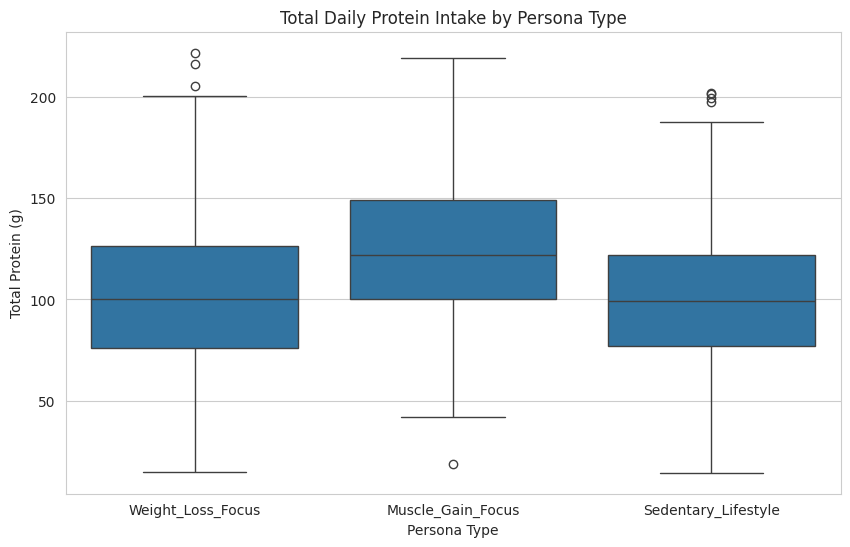

EDA shows that the 'Muscle_Gain_Focus' persona has a higher protein intake, as intended.


In [ ]:
# ==============================================================================
# Section 4: Exploratory Data Analysis (EDA) on Generated Data
# ==============================================================================
# We analyze our generated dataset to ensure the personas are distinct and the
# data is plausible. This validates our generation logic.

print("\n--- Section 4: EDA on Generated Data ---")

# --- 4.1: Analyze Protein Intake by Persona ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_generated, x='persona_type', y='total_protein_g')
plt.title('Total Daily Protein Intake by Persona Type')
plt.ylabel('Total Protein (g)')
plt.xlabel('Persona Type')
plt.show()
print("EDA shows that the 'Muscle_Gain_Focus' persona has a higher protein intake, as intended.")


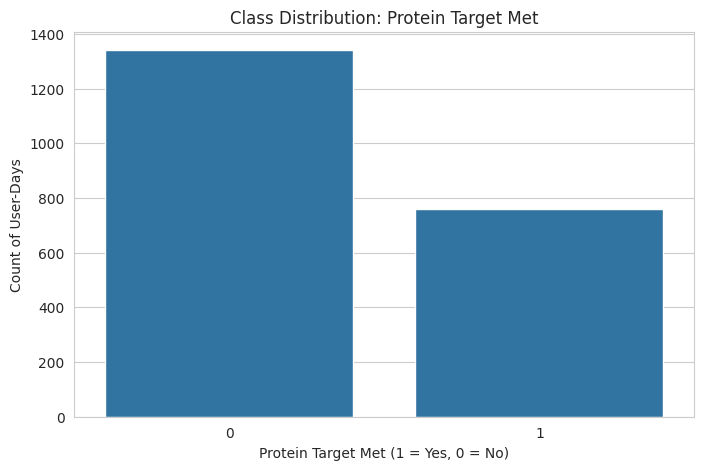

The target variable is reasonably balanced.


In [ ]:
# --- 4.2: Analyze the Target Variable Distribution ---
plt.figure(figsize=(8, 5))
sns.countplot(data=df_generated, x='protein_target_met')
plt.title('Class Distribution: Protein Target Met')
plt.xlabel('Protein Target Met (1 = Yes, 0 = No)')
plt.ylabel('Count of User-Days')
plt.show()
print("The target variable is reasonably balanced.")


In [ ]:
# ==============================================================================
# Section 5: Feature Engineering & Preprocessing for ML
# ==============================================================================
# Now we prepare the data for our machine learning models. We define our features
# and target, handle categorical variables, and scale the data.

print("\n--- Section 5: Feature Engineering & Preprocessing ---")

# --- 5.1: Define Features (X) and Target (y) ---
# CRITICAL: We do NOT include 'total_protein_g' in the features, as that would
# directly leak the answer for the target 'protein_target_met'.
features_to_drop = ['user_id', 'day', 'total_protein_g', 'protein_target_g', 'protein_target_met']
X = df_generated.drop(columns=features_to_drop)
y = df_generated['protein_target_met']

# --- 5.2: Handle Categorical Features using One-Hot Encoding ---
X = pd.get_dummies(X, columns=['persona_type', 'activity_level'], drop_first=True)

# --- 5.3: Split Data into Training and Testing Sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- 5.4: Scale Numerical Features ---
# Identify numerical columns to scale after one-hot encoding
numerical_cols = X.select_dtypes(include=np.number).columns
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print("Data has been preprocessed and split for modeling.")
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)



--- Section 5: Feature Engineering & Preprocessing ---
Data has been preprocessed and split for modeling.
Training set shape: (1680, 9)
Testing set shape: (420, 9)



--- Section 6: Model Training & Evaluation ---
--- Logistic Regression (Baseline) ---
Accuracy: 0.8262
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.86      0.86       268
           1       0.76      0.76      0.76       152

    accuracy                           0.83       420
   macro avg       0.81      0.81      0.81       420
weighted avg       0.83      0.83      0.83       420


--- Random Forest (Primary Model) ---
Accuracy: 0.8095
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85       268
           1       0.76      0.69      0.72       152

    accuracy                           0.81       420
   macro avg       0.80      0.78      0.79       420
weighted avg       0.81      0.81      0.81       420



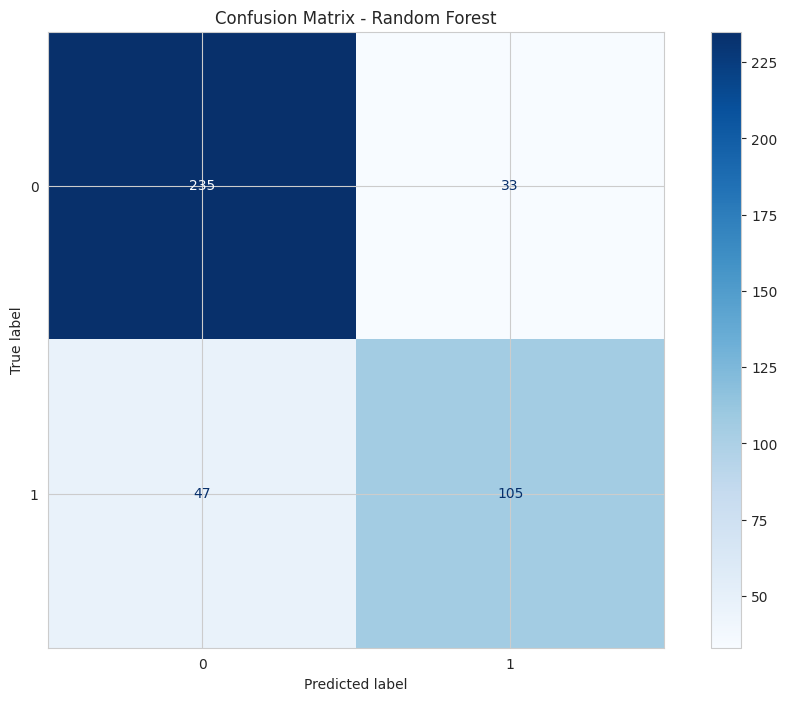

In [ ]:
# ==============================================================================
# Section 6: Model Training & Evaluation
# ==============================================================================
# We train our baseline (Logistic Regression) and primary (Random Forest) models
# and evaluate their performance on the test set.

print("\n--- Section 6: Model Training & Evaluation ---")

# --- 6.1: Logistic Regression (Baseline) ---
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
print("--- Logistic Regression (Baseline) ---")
print(f"Accuracy: {accuracy_score(y_test, lr_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, lr_pred))

# --- 6.2: Random Forest Classifier (Primary Model) ---
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print("\n--- Random Forest (Primary Model) ---")
print(f"Accuracy: {accuracy_score(y_test, rf_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, rf_pred))

# --- 6.3: Confusion Matrix for Random Forest ---
cm = confusion_matrix(y_test, rf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.show()



--- Section 7: Model Interpretation ---


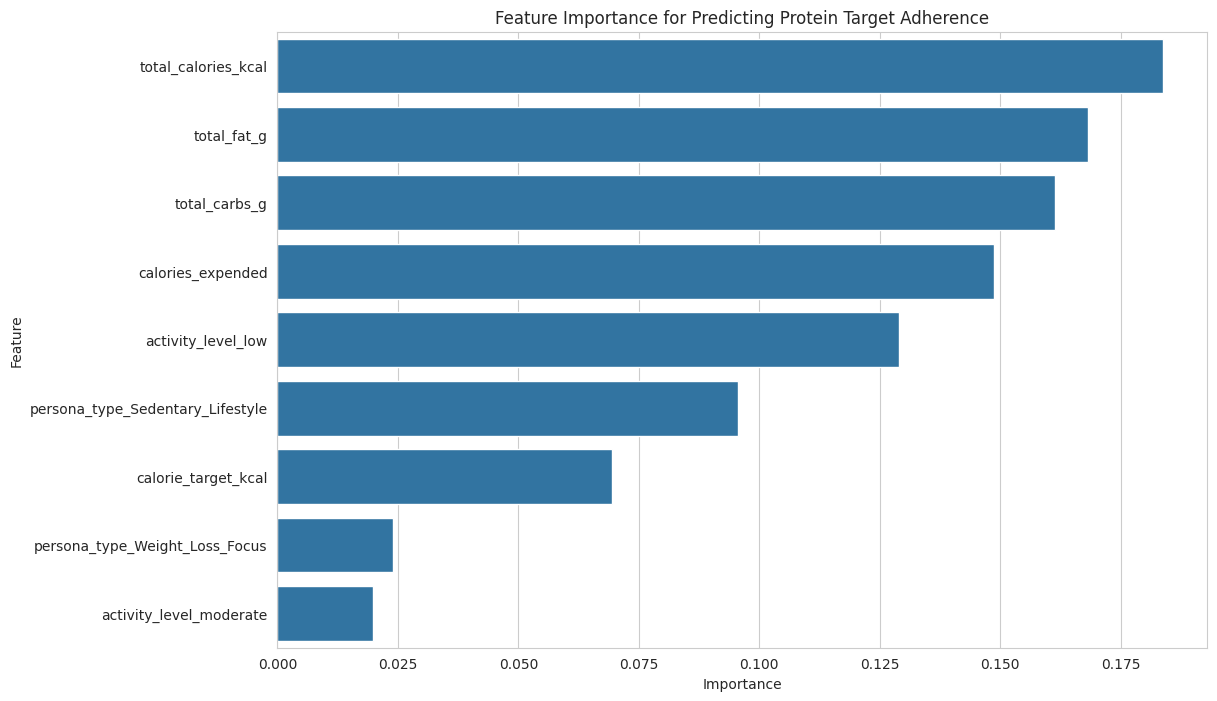

Analysis: The model's feature importance plot reveals key drivers for protein target adherence...


In [ ]:
# ==============================================================================
# Section 7: Model Interpretation & Explainability
# ==============================================================================
# We analyze the Random Forest model to understand which factors are most
# predictive of a user meeting their protein target.

print("\n--- Section 7: Model Interpretation ---")

importances = rf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance_df, x='importance', y='feature')
plt.title('Feature Importance for Predicting Protein Target Adherence')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

print("Analysis: The model's feature importance plot reveals key drivers for protein target adherence...")


In [ ]:
# ==============================================================================
# Section 8: Rule-Based Recommendation System (Upgraded)
# ==============================================================================
# This upgraded recommender operates on a user's daily summary data and can
# incorporate the AI model's prediction.

print("\n--- Section 8: Rule-Based Recommendation System ---")

# We'll use the trained Random Forest model to add predictions to our test set
X_test_with_preds = X_test.copy()
X_test_with_preds['prediction'] = rf.predict(X_test)
X_test_with_preds['true_label'] = y_test

# Re-add some original columns for more context in rules
original_context = df_generated.loc[X_test_with_preds.index, ['persona_type', 'total_protein_g', 'protein_target_g']]
X_test_with_context = X_test_with_preds.join(original_context)


def get_daily_recommendation(row):
    """
    Generates a recommendation based on a row of daily user data.
    """
    recommendations = []

    # Rule 1: Based on AI prediction
    if row['prediction'] == 0: # Model predicts they will NOT meet the target
        protein_needed = row['protein_target_g'] - row['total_protein_g']
        if protein_needed > 20:
             recommendations.append(f"AI predicts you'll miss your protein goal. Try adding a high-protein snack like Greek yogurt or a protein shake to add ~{protein_needed:.0f}g.")

    # Rule 2: Based on Calorie balance
    calorie_balance = row['total_calories_kcal'] - row['calorie_target_kcal']
    if calorie_balance > 300:
        recommendations.append("Your calorie intake is significantly over target. Consider opting for a lighter dinner or reducing portion sizes.")

    # Rule 3: Based on Fat intake
    if row['total_fat_g'] > 90:
        recommendations.append("Your fat intake seems high today. Try choosing leaner protein sources or reducing oils/butter.")

    if not recommendations:
        return "Your nutrition looks balanced for the day. Keep it up!"

    return " | ".join(recommendations)

# Demonstrate on a few samples
X_test_with_context['recommendation'] = X_test_with_context.apply(get_daily_recommendation, axis=1)

print("Sample Recommendations:")
print(X_test_with_context[['persona_type', 'total_protein_g', 'protein_target_g', 'prediction', 'recommendation']].head(10))




--- Section 8: Rule-Based Recommendation System ---
Sample Recommendations:
             persona_type  total_protein_g  protein_target_g  prediction  \
1371    Muscle_Gain_Focus            160.2               180           0   
414     Weight_Loss_Focus             60.6               120           0   
1803  Sedentary_Lifestyle             52.4                80           0   
1267    Muscle_Gain_Focus            136.3               180           0   
1779  Sedentary_Lifestyle            121.5                80           1   
1401  Sedentary_Lifestyle            133.4                80           1   
168     Weight_Loss_Focus             64.7               120           0   
1969  Sedentary_Lifestyle             64.8                80           0   
1107    Muscle_Gain_Focus            125.9               180           0   
1299    Muscle_Gain_Focus            153.2               180           0   

                                         recommendation  
1371  Your nutrition looks b

In [ ]:
# ==============================================================================
# Section 9: AI Ethics & Explainability
# ==============================================================================

print("\n--- Section 9: AI Ethics & Explainability ---")
print("""
This notebook and the developed models adhere to several ethical and explainability principles:

1.  **Mitigating Bias:** By consciously designing diverse user personas (Weight Loss, Muscle Gain, Sedentary), we take a first step towards ensuring our training data is not skewed towards a single user type. The model's performance should be evaluated across these personas to check for fairness.

2.  **Data Privacy:** The project exclusively uses a public food dataset and synthetically generated user data. No Personally Identifiable Information (PII) is collected or handled, adhering to privacy-by-design principles.

3.  **Explainability & Interpretability:**
    *   The Feature Importance plot (Section 7) provides clear insights into what factors the Random Forest model considers most important when making predictions. This helps to 'open the black box'.
    *   The Rule-Based Recommendation System (Section 8) is inherently transparent. The logic is coded in clear IF-THEN statements, making the reasons for a specific recommendation auditable and understandable.

4.  **Advisory, Not Medical:** A key ethical consideration is ensuring the user understands the system's limitations. All recommendations generated are intended as advisory 'nudges' and not as medical prescriptions. A real-world application would require prominent disclaimers.
""")


--- Section 9: AI Ethics & Explainability ---

This notebook and the developed models adhere to several ethical and explainability principles:

1.  **Mitigating Bias:** By consciously designing diverse user personas (Weight Loss, Muscle Gain, Sedentary), we take a first step towards ensuring our training data is not skewed towards a single user type. The model's performance should be evaluated across these personas to check for fairness.

2.  **Data Privacy:** The project exclusively uses a public food dataset and synthetically generated user data. No Personally Identifiable Information (PII) is collected or handled, adhering to privacy-by-design principles.

3.  **Explainability & Interpretability:**
    *   The Feature Importance plot (Section 7) provides clear insights into what factors the Random Forest model considers most important when making predictions. This helps to 'open the black box'.
    *   The Rule-Based Recommendation System (Section 8) is inherently transparent. The 